In [12]:
%run 'Data Cleaning.ipynb'

In [13]:
jobs_cleaned.head()

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,scraped,skill_name,industry_name
0,3757940104,553718.0,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,63000.0,NaN,MONTHLY,Full-time,"Little River, SC",...,NaN,1.699090e+12,careers-demant.icims.com,0,FULL_TIME,USD,BASE_SALARY,1699138101,Other,Medical Equipment Manufacturing
4,3757938018,18213359.0,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,46321.6,NaN,HOURLY,Full-time,"Aliso Viejo, CA",...,NaN,1.699080e+12,jobs.apploi.com,0,FULL_TIME,USD,BASE_SALARY,1699087461,Management,Non-profit Organizations
5,3757938018,18213359.0,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,46321.6,NaN,HOURLY,Full-time,"Aliso Viejo, CA",...,NaN,1.699080e+12,jobs.apploi.com,0,FULL_TIME,USD,BASE_SALARY,1699087461,Manufacturing,Non-profit Organizations
6,3757937095,437225.0,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,240895.0,205956.0,YEARLY,Full-time,United States,...,NaN,1.699090e+12,careers.iherb.com,0,FULL_TIME,USD,BASE_SALARY,1699085346,Information Technology,"Technology, Information and Internet"
7,3757937095,437225.0,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,240895.0,205956.0,YEARLY,Full-time,United States,...,NaN,1.699090e+12,careers.iherb.com,0,FULL_TIME,USD,BASE_SALARY,1699085346,Information Technology,Manufacturing


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

med_P = np.nanpercentile(jobs_cleaned['med_salary'], [1, 99])
jobs_cleaned = jobs_cleaned[(jobs_cleaned['med_salary'] > med_P[0]) & (jobs_cleaned['med_salary'] < med_P[1])]

min_P = np.nanpercentile(jobs_cleaned['min_salary'], [1, 99])
jobs_cleaned = jobs_cleaned[(jobs_cleaned['min_salary'] > min_P[0]) & (jobs_cleaned['min_salary'] < min_P[1])]

max_P = np.nanpercentile(jobs_cleaned['max_salary'], [1, 99])
jobs_cleaned = jobs_cleaned[(jobs_cleaned['min_salary'] > max_P[0]) & (jobs_cleaned['min_salary'] < max_P[1])]

# jobs_cleaned.to_csv('jobs_cleaned.csv')

# Create a new LabelEncoder for each categorical column
title_encoder = LabelEncoder()
location_encoder = LabelEncoder()
skill_name_encoder = LabelEncoder()
experience_level_encoder = LabelEncoder()

# Fit and transform each column with its respective encoder
jobs_cleaned['title_enc'] = title_encoder.fit_transform(jobs_cleaned['title'])
jobs_cleaned['location_enc'] = location_encoder.fit_transform(jobs_cleaned['location'])
jobs_cleaned['skill_name_enc'] = skill_name_encoder.fit_transform(jobs_cleaned['skill_name'])
jobs_cleaned['formatted_experience_level_enc'] = experience_level_encoder.fit_transform(jobs_cleaned['formatted_experience_level'])


X = jobs_cleaned[['title_enc', 'location_enc','skill_name_enc','formatted_experience_level_enc']]

## XGBoost

In [4]:
def train_salary_model(salary_level):
    # Select the salary level for prediction
    y = jobs_cleaned[salary_level]
    
    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    # Initializing and training the XGBoost regressor model
    # After running a few grid searches I found that each model had the same best parameters
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.2,
                              max_depth = 5, n_estimators = 1000)
    xg_reg.fit(X_train, y_train)

    # Making predictions on the test set
    y_pred = xg_reg.predict(X_test)

    # Calculating the RMSE for the predictions
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    
    # Returning the trained model
    return xg_reg, salary_level, y_test, y_pred, rmse

In [5]:
def model_eval(model, salary_level, y_test, y_pred, rmse):

    print(f"Salary Level: {salary_level}")
    print(f"RMSE: {rmse}")
    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual Salaries')
    plt.ylabel('Predicted Salaries')
    plt.title(f'Actual vs. Predicted Salaries ({salary_level})')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.show()

Salary Level: min_salary
RMSE: 19820.9748180707


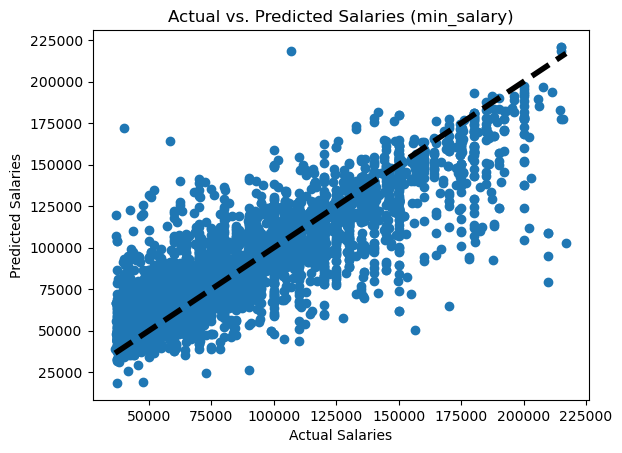

Salary Level: max_salary
RMSE: 33348.67012218484


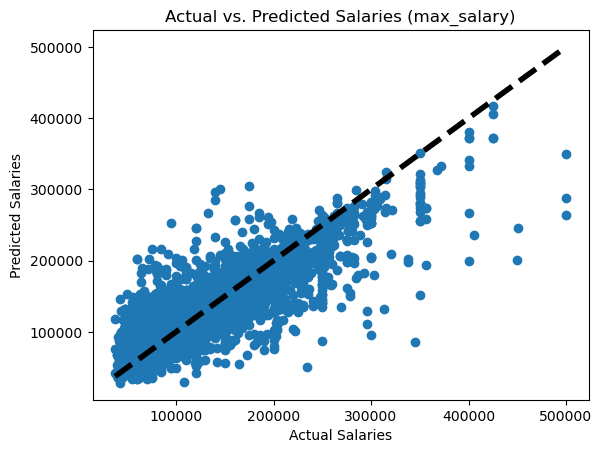

Salary Level: med_salary
RMSE: 25061.2225622539


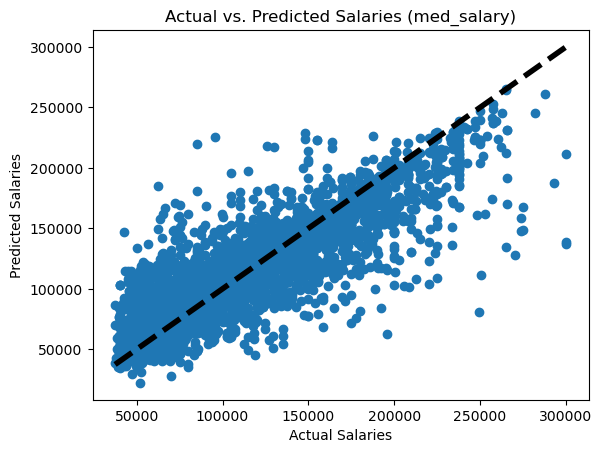

In [6]:
models = ['min_salary','max_salary','med_salary']
for model in models:
    model_eval(*train_salary_model(model))

In [7]:

# med_salary_model, _, _, _, _ = train_salary_model('med_salary')
# min_salary_model, _, _, _, _ = train_salary_model('min_salary')
# max_salary_model, _, _, _, _ = train_salary_model('max_salary')


# med_salary_model.save_model('med_model.json')
# min_salary_model.save_model('min_model.json')
# max_salary_model.save_model('max_model.json')

In [8]:
# xgb = xgb.XGBRegressor()

# xgb.load_model('med_model.json')

### Min, Median, Max estimator

In [9]:
med_salary_model, _, _, _, _ = train_salary_model('med_salary')
min_salary_model, _, _, _, _ = train_salary_model('min_salary')
max_salary_model, _, _, _, _ = train_salary_model('max_salary')

# Example user input
for location in jobs_cleaned['location'].unique():
    user_input = {
        'title_enc': ['Data Scientist'],
        'location_enc': [f'{location}'],
        'skill_name_enc': ['Information Technology'],
        'formatted_experience_level_enc': ['Mid-Senior level']
    }

    user_input_df = pd.DataFrame(user_input)

    user_input_df['title_enc'] = title_encoder.transform(user_input_df['title_enc'])
    user_input_df['location_enc'] = location_encoder.transform(user_input_df['location_enc'])
    user_input_df['skill_name_enc'] = skill_name_encoder.transform(user_input_df['skill_name_enc'])
    user_input_df['formatted_experience_level_enc'] = experience_level_encoder.transform(user_input_df['formatted_experience_level_enc'])

    # Predict the salary for the user input
    min_predicted_salary = min_salary_model.predict(user_input_df)
    median_predicted_salary = med_salary_model.predict(user_input_df)
    max_predicted_salary = max_salary_model.predict(user_input_df)

    print(f"----{location}-----")
    print(f"\n Estimated salary: ${min_predicted_salary[0]:,.2f} - ${median_predicted_salary[0]:,.2f} - ${max_predicted_salary[0]:,.2f} \n")

----United States-----

 Estimated salary: $173,930.30 - $183,780.94 - $197,439.11 

----Coeur d'Alene, ID-----

 Estimated salary: $127,355.34 - $156,723.31 - $170,532.81 

----Waukesha, WI-----

 Estimated salary: $147,533.12 - $149,743.92 - $170,604.33 

----Orlando, FL-----

 Estimated salary: $123,336.18 - $152,384.77 - $168,102.91 

----Oakland, CA-----

 Estimated salary: $140,964.92 - $155,597.81 - $170,635.92 

----Broomfield, CO-----

 Estimated salary: $108,193.84 - $134,934.58 - $180,081.42 

----Swedesboro, NJ-----

 Estimated salary: $146,231.19 - $158,438.56 - $196,604.19 

----Richmond, VA-----

 Estimated salary: $133,105.95 - $164,786.02 - $166,268.08 

----Rapid City, SD-----

 Estimated salary: $117,762.38 - $151,126.89 - $223,242.33 

----Yuma, AZ-----

 Estimated salary: $130,032.95 - $148,904.69 - $196,684.61 

----Sheboygan, WI-----

 Estimated salary: $131,443.12 - $161,516.41 - $195,783.55 

----Portland, OR-----

 Estimated salary: $131,125.45 - $156,164.64 -

----Salt Lake City, UT-----

 Estimated salary: $116,411.27 - $149,529.30 - $182,901.11 

----Austin, TX-----

 Estimated salary: $119,660.62 - $157,791.33 - $196,090.92 

----Eugene, OR-----

 Estimated salary: $108,633.27 - $134,441.09 - $154,873.42 

----Osseo, MN-----

 Estimated salary: $123,336.18 - $152,384.77 - $168,102.91 

----Worcester, MA-----

 Estimated salary: $130,032.95 - $148,904.69 - $196,684.61 

----Portsmouth, NH-----

 Estimated salary: $131,125.45 - $156,164.64 - $182,847.69 

----Waltham, MA-----

 Estimated salary: $156,038.17 - $165,635.09 - $183,938.41 

----Surprise, AZ-----

 Estimated salary: $146,231.19 - $158,438.56 - $196,604.19 

----Scottsdale, AZ-----

 Estimated salary: $127,804.44 - $151,662.95 - $180,384.83 

----Jacksonville, FL-----

 Estimated salary: $124,696.77 - $159,148.44 - $182,978.48 

----Weatherford, TX-----

 Estimated salary: $147,533.12 - $149,743.92 - $170,604.33 

----Hercules, CA-----

 Estimated salary: $128,704.08 - $152,483.4

----Peoria, AZ-----

 Estimated salary: $119,613.59 - $145,683.94 - $165,488.39 

----Acampo, CA-----

 Estimated salary: $73,416.92 - $95,775.41 - $127,324.94 

----Whittier, CA-----

 Estimated salary: $134,846.31 - $152,832.67 - $229,098.22 

----The Colony, TX-----

 Estimated salary: $154,014.47 - $168,576.91 - $195,243.84 

----Rochester, NY-----

 Estimated salary: $121,329.41 - $141,003.39 - $159,291.78 

----Melville, NY-----

 Estimated salary: $131,973.78 - $167,911.91 - $176,860.69 

----Liberty Lake, WA-----

 Estimated salary: $130,870.71 - $164,156.64 - $193,988.80 

----Mountain View, CA-----

 Estimated salary: $156,883.77 - $186,944.12 - $210,703.62 

----Gardena, CA-----

 Estimated salary: $127,997.59 - $155,527.69 - $187,004.81 

----Pasadena, CA-----

 Estimated salary: $117,262.97 - $143,987.39 - $167,094.47 

----Truckee, CA-----

 Estimated salary: $145,182.19 - $160,112.62 - $180,300.88 

----Ohio, United States-----

 Estimated salary: $140,964.92 - $155,597.

----Stamford, CT-----

 Estimated salary: $141,974.25 - $157,036.22 - $194,270.92 

----San Juan Capistrano, CA-----

 Estimated salary: $143,314.56 - $178,649.09 - $206,002.59 

----Benicia, CA-----

 Estimated salary: $104,884.97 - $146,513.94 - $190,065.33 

----West Point, PA-----

 Estimated salary: $158,164.22 - $173,669.20 - $220,280.75 

----Wytheville, VA-----

 Estimated salary: $130,032.95 - $148,904.69 - $196,684.61 

----Port Washington, NY-----

 Estimated salary: $130,265.66 - $156,798.36 - $191,781.33 

----Greater Indianapolis-----

 Estimated salary: $130,839.25 - $154,314.47 - $179,109.00 

----Aurora, CO-----

 Estimated salary: $114,069.16 - $145,482.11 - $193,665.55 

----Junction City, KS-----

 Estimated salary: $152,637.84 - $192,478.81 - $218,371.09 

----Hayward, CA-----

 Estimated salary: $134,678.70 - $162,257.23 - $186,655.73 

----Port Hueneme, CA-----

 Estimated salary: $130,265.66 - $156,798.36 - $191,781.33 

----Fremont, CA-----

 Estimated salary: 

----Amherst, NH-----

 Estimated salary: $97,306.53 - $128,865.30 - $168,806.89 

----Cartersville, GA-----

 Estimated salary: $119,466.60 - $160,765.27 - $185,221.42 

----Pasadena, TX-----

 Estimated salary: $117,262.97 - $143,987.39 - $167,094.47 

----Bartlett, IL-----

 Estimated salary: $104,571.72 - $140,376.23 - $173,878.05 

----Gypsum, CO-----

 Estimated salary: $123,009.75 - $153,361.06 - $178,002.64 

----Danbury, CT-----

 Estimated salary: $142,341.02 - $190,583.58 - $231,464.69 

----Gaithersburg, MD-----

 Estimated salary: $127,997.59 - $155,527.69 - $187,004.81 

----Piqua, OH-----

 Estimated salary: $133,897.31 - $152,727.02 - $178,774.17 

----Holland, MI-----

 Estimated salary: $122,660.70 - $143,445.59 - $184,898.67 

----Madison, WI-----

 Estimated salary: $132,726.39 - $158,643.45 - $176,820.88 

----Riviera Beach, FL-----

 Estimated salary: $133,105.95 - $164,786.02 - $166,268.08 

----Santa Monica, CA-----

 Estimated salary: $131,299.00 - $158,978.31 -

----Peachtree Corners, GA-----

 Estimated salary: $117,262.97 - $143,987.39 - $167,094.47 

----Columbia, SC-----

 Estimated salary: $121,112.20 - $155,254.89 - $167,542.38 

----Falls Church, VA-----

 Estimated salary: $116,981.00 - $141,106.17 - $153,007.28 

----Billerica, MA-----

 Estimated salary: $108,820.48 - $147,506.11 - $185,787.14 

----Beltsville, MD-----

 Estimated salary: $104,884.97 - $146,513.94 - $190,065.33 

----Jackson, MS-----

 Estimated salary: $124,696.77 - $159,148.44 - $182,978.48 

----Winter Haven, FL-----

 Estimated salary: $141,401.67 - $156,738.38 - $206,023.36 

----Garden Grove, CA-----

 Estimated salary: $127,997.59 - $155,527.69 - $187,004.81 

----Jackson, MI-----

 Estimated salary: $124,696.77 - $159,148.44 - $182,978.48 

----Vallejo, CA-----

 Estimated salary: $173,930.30 - $183,780.94 - $197,439.11 

----Lebanon, KY-----

 Estimated salary: $133,613.66 - $157,507.84 - $187,829.19 

----Raleigh, NC-----

 Estimated salary: $117,762.38 - $

----Manhattan, KS-----

 Estimated salary: $133,073.20 - $161,096.02 - $177,792.95 

----Dallas-Fort Worth Metroplex-----

 Estimated salary: $142,341.02 - $190,583.58 - $231,464.69 

----Livonia, MI-----

 Estimated salary: $128,106.04 - $151,754.34 - $166,069.47 

----Wilmington, NC-----

 Estimated salary: $134,846.31 - $152,832.67 - $229,098.22 

----Edison, NJ-----

 Estimated salary: $129,466.95 - $163,171.53 - $187,542.66 

----Rochester, New York Metropolitan Area-----

 Estimated salary: $121,329.41 - $141,003.39 - $159,291.78 

----Pittsburg, CA-----

 Estimated salary: $133,897.31 - $152,727.02 - $178,774.17 

----Farmington, ME-----

 Estimated salary: $116,981.00 - $141,106.17 - $153,007.28 

----Bristol, CT-----

 Estimated salary: $127,025.68 - $158,607.41 - $193,251.05 

----Charleston, WV-----

 Estimated salary: $117,429.16 - $165,423.73 - $186,491.22 

----Coral Springs, FL-----

 Estimated salary: $130,100.03 - $188,618.59 - $236,603.33 

----Georgia, United States-

----Petaluma, CA-----

 Estimated salary: $119,613.59 - $145,683.94 - $165,488.39 

----Meridian, ID-----

 Estimated salary: $131,973.78 - $167,911.91 - $176,860.69 

----Burien, WA-----

 Estimated salary: $109,829.01 - $144,452.06 - $185,157.17 

----Walnut Creek, CA-----

 Estimated salary: $156,038.17 - $165,635.09 - $183,938.41 

----Owings Mills, MD-----

 Estimated salary: $116,653.14 - $142,234.48 - $188,082.47 

----Issaquah, WA-----

 Estimated salary: $124,696.77 - $159,148.44 - $182,978.48 

----Patterson, OH-----

 Estimated salary: $117,262.97 - $143,987.39 - $167,094.47 

----Gig Harbor, WA-----

 Estimated salary: $122,541.85 - $147,604.19 - $171,376.38 

----Oldsmar, FL-----

 Estimated salary: $140,964.92 - $155,597.81 - $170,635.92 

----Overland Park, KS-----

 Estimated salary: $123,336.18 - $152,384.77 - $168,102.91 

----East Longmeadow, MA-----

 Estimated salary: $125,402.63 - $161,423.70 - $192,410.53 

----Avondale, AZ-----

 Estimated salary: $102,234.36 - 

----Round Rock, TX-----

 Estimated salary: $109,125.16 - $138,712.98 - $159,195.91 

----Northern, VA-----

 Estimated salary: $116,343.34 - $141,982.52 - $160,328.25 

----Panama City, FL-----

 Estimated salary: $134,526.97 - $173,920.03 - $217,288.78 

----Monroe, MI-----

 Estimated salary: $121,826.42 - $147,945.81 - $153,773.17 

----Park City, UT-----

 Estimated salary: $134,526.97 - $173,920.03 - $217,288.78 

----Macomb, MI-----

 Estimated salary: $132,726.39 - $158,643.45 - $176,820.88 

----East Aurora, NY-----

 Estimated salary: $125,402.63 - $161,423.70 - $192,410.53 

----Vernon, CA-----

 Estimated salary: $155,906.50 - $155,465.20 - $173,083.83 

----Irvine, California, United States-----

 Estimated salary: $129,486.73 - $162,092.50 - $189,775.84 

----San Juan Bautista, CA-----

 Estimated salary: $143,314.56 - $178,649.09 - $206,002.59 

----Oxnard, CA-----

 Estimated salary: $116,653.14 - $142,234.48 - $188,082.47 

----New Berlin, WI-----

 Estimated salary: $

----Glastonbury, CT-----

 Estimated salary: $122,541.85 - $147,604.19 - $171,376.38 

----Branchville, NJ-----

 Estimated salary: $117,741.50 - $149,665.14 - $188,075.42 

----Seeley Lake, MT-----

 Estimated salary: $131,443.12 - $161,516.41 - $195,783.55 

----Sun Valley, CA-----

 Estimated salary: $140,154.22 - $149,112.62 - $196,619.08 

----Roseville, CA-----

 Estimated salary: $109,125.16 - $138,712.98 - $159,195.91 

----Bluffdale, UT-----

 Estimated salary: $100,868.30 - $135,049.20 - $169,283.88 

----Stanford, CA-----

 Estimated salary: $126,988.19 - $139,840.88 - $168,057.02 

----Greenville County, SC-----

 Estimated salary: $130,992.86 - $159,013.52 - $181,179.19 

----Edwards, CA-----

 Estimated salary: $129,466.95 - $163,171.53 - $187,542.66 

----Lenox, IA-----

 Estimated salary: $128,783.47 - $155,895.78 - $191,543.00 

----Warner Robins, GA-----

 Estimated salary: $156,038.17 - $165,635.09 - $183,938.41 

----Davis County, UT-----

 Estimated salary: $142,34

----West Babylon, NY-----

 Estimated salary: $148,973.41 - $159,810.42 - $170,929.67 

----Memphis Metropolitan Area-----

 Estimated salary: $131,973.78 - $167,911.91 - $176,860.69 

----Passaic, NJ-----

 Estimated salary: $117,262.97 - $143,987.39 - $167,094.47 

----Memphis metropolitan area, MS-----

 Estimated salary: $131,973.78 - $167,911.91 - $176,860.69 

----Duluth, MN-----

 Estimated salary: $137,622.86 - $172,169.03 - $196,390.91 

----Woburn, MA-----

 Estimated salary: $141,401.67 - $156,738.38 - $206,023.36 

----Tallahassee, FL-----

 Estimated salary: $139,414.58 - $150,634.56 - $193,179.78 

----Ronkonkoma, NY-----

 Estimated salary: $121,329.41 - $141,003.39 - $159,291.78 

----Silicon Valley, CA-----

 Estimated salary: $126,958.48 - $156,959.25 - $188,377.28 

----Johnstown, CO-----

 Estimated salary: $152,637.84 - $192,478.81 - $218,371.09 

----Sheboygan Falls, WI-----

 Estimated salary: $131,443.12 - $161,516.41 - $195,783.55 

----Delaware, United States-

----Simpsonville, SC-----

 Estimated salary: $126,958.48 - $156,959.25 - $188,377.28 

----Clinton, SC-----

 Estimated salary: $127,355.34 - $156,723.31 - $170,532.81 

----Blue Bell, PA-----

 Estimated salary: $100,868.30 - $135,049.20 - $169,283.88 

----McDonough, GA-----

 Estimated salary: $122,234.18 - $158,739.39 - $168,812.91 

----Bath, PA-----

 Estimated salary: $110,327.68 - $145,008.78 - $186,037.42 

----Turlock, CA-----

 Estimated salary: $165,553.14 - $181,750.19 - $204,207.34 

----Windsor, CO-----

 Estimated salary: $141,401.67 - $156,738.38 - $206,023.36 

----Rolla, MO-----

 Estimated salary: $121,329.41 - $141,003.39 - $159,291.78 

----Terre Haute, IN-----

 Estimated salary: $152,601.00 - $156,410.30 - $179,336.12 

----Red Oak, TX-----

 Estimated salary: $122,120.18 - $160,054.69 - $245,291.75 

----Eureka, CA-----

 Estimated salary: $108,633.27 - $134,441.09 - $154,873.42 

----Greater Macon-----

 Estimated salary: $130,839.25 - $154,314.47 - $179,109.

----Westmont, IL-----

 Estimated salary: $158,164.22 - $173,669.20 - $220,280.75 

----Riverhead, NY-----

 Estimated salary: $133,105.95 - $164,786.02 - $166,268.08 

----Agoura Hills, CA-----

 Estimated salary: $73,416.92 - $95,775.41 - $127,324.94 

----Rosemount, MN-----

 Estimated salary: $121,329.41 - $141,003.39 - $159,291.78 

----Arden, NC-----

 Estimated salary: $97,932.30 - $135,463.30 - $169,738.33 

----Winston-Salem, NC-----

 Estimated salary: $141,401.67 - $156,738.38 - $206,023.36 

----Marina del Rey, CA-----

 Estimated salary: $122,234.18 - $158,739.39 - $168,812.91 

----Clearwater, Florida, United States-----

 Estimated salary: $116,725.46 - $137,717.02 - $167,709.39 

----Ironwood, MI-----

 Estimated salary: $123,497.73 - $155,434.77 - $186,617.62 

----Beaverton, OR-----

 Estimated salary: $110,327.68 - $145,008.78 - $186,037.42 

----Deerfield Beach, FL-----

 Estimated salary: $119,110.84 - $142,190.64 - $154,208.00 

----Mauldin, SC-----

 Estimated sa

----Huntington, NY-----

 Estimated salary: $134,778.42 - $159,467.75 - $188,286.47 

----Escanaba, MI-----

 Estimated salary: $113,555.20 - $138,114.53 - $158,741.83 

----Berwyn, PA-----

 Estimated salary: $108,820.48 - $147,506.11 - $185,787.14 

----Canton, MA-----

 Estimated salary: $123,756.05 - $165,877.52 - $206,670.95 

----Ames, IA-----

 Estimated salary: $97,306.53 - $128,865.30 - $168,806.89 

----Hopland, CA-----

 Estimated salary: $122,660.70 - $143,445.59 - $184,898.67 

----Redlands, CA-----

 Estimated salary: $122,120.18 - $160,054.69 - $245,291.75 

----Grass Valley, CA-----

 Estimated salary: $121,726.27 - $139,410.73 - $159,028.33 

----Gallatin, TN-----

 Estimated salary: $127,997.59 - $155,527.69 - $187,004.81 

----Harbeson, DE-----

 Estimated salary: $123,009.75 - $153,361.06 - $178,002.64 

----Minnesota, United States-----

 Estimated salary: $128,272.83 - $160,311.61 - $169,615.64 

----Washington, PA-----

 Estimated salary: $147,533.12 - $149,743.9

----Macon, GA-----

 Estimated salary: $132,726.39 - $158,643.45 - $176,820.88 

----Hilton Head Island, SC-----

 Estimated salary: $128,704.08 - $152,483.44 - $168,901.22 

----Hugo, MN-----

 Estimated salary: $134,778.42 - $159,467.75 - $188,286.47 

----Reading, PA-----

 Estimated salary: $117,762.38 - $151,126.89 - $223,242.33 

----Selah, WA-----

 Estimated salary: $131,443.12 - $161,516.41 - $195,783.55 

----Port Arthur, TX-----

 Estimated salary: $129,397.02 - $152,838.83 - $178,899.89 

----Belton, MO-----

 Estimated salary: $104,884.97 - $146,513.94 - $190,065.33 

----El Cajon, CA-----

 Estimated salary: $129,466.95 - $163,171.53 - $187,542.66 

----Hollister, CA-----

 Estimated salary: $122,660.70 - $143,445.59 - $184,898.67 

----Billings, MT-----

 Estimated salary: $108,820.48 - $147,506.11 - $185,787.14 

----Davis, CA-----

 Estimated salary: $142,341.02 - $190,583.58 - $231,464.69 

----Greater Bangor Area-----

 Estimated salary: $121,726.27 - $139,410.73 - $

### Job Title Similarity Search

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# List of job titles
job_titles = jobs_cleaned['title'].unique()

# User input job title
user_input_title = input("Enter job title: ")

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the job titles to TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(job_titles)

# Transform the user input job title to TF-IDF vector
user_input_vector = tfidf_vectorizer.transform([user_input_title])

# Compute the cosine similarity between user input job title and each job title in the list
cos_similarity = cosine_similarity(user_input_vector, tfidf_matrix)[0]

# Find the indices of the top 5 cosine similarity scores
top_5_indices = np.argsort(cos_similarity)[-5:]

# Find the most similar job titles in the list
most_similar_job_titles = job_titles[top_5_indices]

# Reverse the array to have the most similar first
most_similar_job_titles = np.flip(most_similar_job_titles)

print("The top 5 most similar job titles are:", most_similar_job_titles)


Enter job title: data analyst
The top 5 most similar job titles are: ['Data Analyst' 'Senior Data Analyst' 'Business Data Analyst'
 'Product Data Analyst' 'Healthcare Data Analyst']


### Job Description Similarity Search

In [11]:
jobs = jobs_cleaned[['title','description']]
job_descriptions = jobs['description'].tolist()  # Use list for maintaining order
job_titles = jobs['title'].tolist()  # This will not be used directly but ensures we're aligned with descriptions

# User input job description
# user_input_description = """
# I want to use SQL and Python to build data visualizations and solve problems with data analysis
# """

user_input_description = input("Enter job description: ")

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the job descriptions to TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(job_descriptions)

# Transform the user input job description to TF-IDF vector
user_input_vector = tfidf_vectorizer.transform([user_input_description])

# Compute the cosine similarity between user input job description and each job description in the list
cos_similarity = cosine_similarity(user_input_vector, tfidf_matrix)[0]

# Find the indices of the top 5 cosine similarity scores
top_5_indices = np.argsort(cos_similarity)[-5:]

# Retrieve the job titles corresponding to these top 5 indices from the original DataFrame
most_similar_job_titles = [jobs.iloc[i]['title'] for i in top_5_indices]

# Reverse the list to have the most similar first
most_similar_job_titles.reverse()

print("The top 5 most related job titles are:", most_similar_job_titles)

Enter job description: I want to use SQL and Python to build data visualizations and solve problems with data analysis
The top 5 most related job titles are: ['Data Analyst', 'Senior Data Engineer', 'IT Data Warehouse Analyst', 'Data Analytics Audit Associate', 'Data Analytics Audit Associate']


In [26]:
med_salary_model, _, _, _, _ = train_salary_model('med_salary')
min_salary_model, _, _, _, _ = train_salary_model('min_salary')
max_salary_model, _, _, _, _ = train_salary_model('max_salary')

city_salaries_df = pd.DataFrame(columns=['city', 'min_predicted_salary', 'median_predicted_salary', 'max_predicted_salary'])

# Example user input
for location in jobs_cleaned['location'].unique():
    user_input = {
        'title_enc': ['Data Scientist'],
        'location_enc': [f'{location}'],
        'skill_name_enc': ['Information Technology'],
        'formatted_experience_level_enc': ['Mid-Senior level']
    }

    user_input_df = pd.DataFrame(user_input)

    user_input_df['title_enc'] = title_encoder.transform(user_input_df['title_enc'])
    user_input_df['location_enc'] = location_encoder.transform(user_input_df['location_enc'])
    user_input_df['skill_name_enc'] = skill_name_encoder.transform(user_input_df['skill_name_enc'])
    user_input_df['formatted_experience_level_enc'] = experience_level_encoder.transform(user_input_df['formatted_experience_level_enc'])

    # Predict the salary for the user input
    city = location
    min_predicted_salary = min_salary_model.predict(user_input_df)
    median_predicted_salary = med_salary_model.predict(user_input_df)
    max_predicted_salary = max_salary_model.predict(user_input_df)
    
    temp_df = pd.DataFrame({
        'city': [city],
        'min_predicted_salary': min_predicted_salary,
        'median_predicted_salary': median_predicted_salary,
        'max_predicted_salary': max_predicted_salary
    })
    
    city_salaries_df = pd.concat([city_salaries_df, temp_df], ignore_index=True)
    

/var/folders/_x/3hvhfs550_j07qx5c00fkgnc0000gn/T/ipykernel_39479/2205547741.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  city_salaries_df = pd.concat([city_salaries_df, temp_df], ignore_index=True)


In [27]:
city_salaries_df

,city,min_predicted_salary,median_predicted_salary,max_predicted_salary
0,United States,173930.296875,183780.937500,197439.109375
1,"Coeur d'Alene, ID",127355.343750,156723.312500,170532.812500
2,"Waukesha, WI",147533.125000,149743.921875,170604.328125
3,"Orlando, FL",123336.179688,152384.765625,168102.906250
4,"Oakland, CA",140964.921875,155597.812500,170635.921875
...,...,...,...,...
1737,"Lafayette, LA",127564.117188,157557.359375,190237.875000
1738,"Madison, GA",132726.390625,158643.453125,176820.875000
1739,"Montebello, CA",125963.304688,148024.593750,152783.718750
1740,"San Gabriel, CA",147363.937500,190756.062500,200727.796875
